In [117]:
import numpy as np
import xarray as xr

import matplotlib.pyplot as plt
import cartopy.crs as ccrs

import matplotlib as mpl

from importlib import reload

In [2]:
import os, sys

# My imports
sys.path.append(os.path.join(os.getcwd(), 'Documents', 'time_of_emergene_drafts'))
sys.path.append(os.path.join(os.getcwd(), 'Documents', 'time_of_emergene_drafts', 'src'))


import constants
import toe_constants as toe_const
import time_of_emergence_calc as toe
toe_calc = toe
import utils

logger = utils.get_notebook_logger()

In [3]:
# from dask.distributed import Client
# client = Client(threads_per_worker=1, n_workers=20)
# client

<h1 style='color:cyan'> Opening Data </h1>

In [4]:
def open_files_datatree(fname_dict, tree_name: str, **kwargs):
    """
    Opens multiple NetCDF files and organizes them into a DataTree.

    Parameters:
    - fname_dict (dict): Dictionary where keys are names and values are file paths.
    - tree_name (str): Name for the root of the DataTree.
    - **kwargs: Additional keyword arguments passed to `xr.open_dataset`.

    Returns:
    - xr.DataTree: A DataTree object containing the datasets.
    """
    data_tree_dict = {}
    for name, path in fname_dict.items():
        ds = xr.open_dataset(path, **kwargs)
        dt = xr.DataTree(ds, name=name)
        data_tree_dict[name] = dt

    tree = xr.DataTree(name=tree_name, children=data_tree_dict)
    return tree


In [5]:
# Create a data set for the base period used as the pre-industrial climate 
# base_period = #(1959, 1989)#(1900, 1950)#(1900, 1931)
base_period = toe_const.YearRange.MODERN_PERIOD
# base_period, base_period.start, base_period.end
base_period_string = str(base_period.value).replace(', ', '_')
base_period_string, base_period

('(1959_1989)', <YearRange.MODERN_PERIOD: (1959, 1989)>)

In [6]:
# Get just the files that have the string 
files = os.listdir(constants.TOE_SAVE_DIR + '/error')
files = [f for f in files if base_period_string in f]
files

['best_temperature_(1959_1989)',
 'era5_t2m_(1959_1989)',
 'gpcc_precip_(1959_1989)',
 'access_pr_(1959_1989)',
 'era5_tcw_(1959_1989)']

In [7]:
os.listdir(os.path.join(constants.TOE_SAVE_DIR + '/error', files[0]))

['data.zarr', 'toe_metrics.zarr', 'signal.zarr']

In [14]:
class FileNameManager:

    def __init__(self, file_names:list, root_path:str):
        self.file_names = file_names
        self.root_path = root_path
        
    def generate_dict(self, fname):
        return {f.split('(')[0][:-1]: os.path.join(self.root_path, f, fname) for f in self.file_names }

In [15]:
base_file_manager = FileNameManager(files, constants.TOE_SAVE_DIR + '/error')

In [17]:
fname_metric_dict = base_file_manager.generate_dict('toe_metrics.zarr')
fname_signal_dict = base_file_manager.generate_dict('signal.zarr')
fname_data_dict = base_file_manager.generate_dict('data.zarr')
fname_data_dict

{'best_temperature': '/g/data/w40/ab2313/time_of_emergence/toe_metrics/error/best_temperature_(1959_1989)/data.zarr',
 'era5_t2m': '/g/data/w40/ab2313/time_of_emergence/toe_metrics/error/era5_t2m_(1959_1989)/data.zarr',
 'gpcc_precip': '/g/data/w40/ab2313/time_of_emergence/toe_metrics/error/gpcc_precip_(1959_1989)/data.zarr',
 'access_pr': '/g/data/w40/ab2313/time_of_emergence/toe_metrics/error/access_pr_(1959_1989)/data.zarr',
 'era5_tcw': '/g/data/w40/ab2313/time_of_emergence/toe_metrics/error/era5_tcw_(1959_1989)/data.zarr'}

In [18]:
toe_metric_tree = open_files_datatree(fname_metric_dict, 'data', engine='zarr', use_cftime=True)

In [19]:
data_tree = open_files_datatree(fname_data_dict, 'data', engine='zarr', use_cftime=True)

In [20]:
signal_tree = open_files_datatree(fname_signal_dict, 'signal', engine='zarr', use_cftime=True)

<h1 style='color:cyan'> ToE Calculation </h1>

In [24]:
def get_test_threshold(test: str) -> float:
    if test in toe_const.PVALUE_TESTS:
        return toe_const.PVALUE_THESHOLD1
    elif test in toe_const.OVERLAP_TESTS:
        return toe_const.OVERLAP_THRESHOLD
    elif 'sn' in test:
        return toe_const.SN_THRESHOLD1
    else:
        # Raise an error for unknown tests
        raise ValueError(f"Unknown test '{test}'. Please check the test name or add it"
                         "to the appropriate category.")

# Test that this function works for all tests
for test in list(toe_metric_tree.best_temperature): threshold = get_test_threshold(test); print(test, threshold)
    

frac 62
hd 62
ks 0.01
perkins 62
sn_hawkins_base 1
sn_hawkins_full 1
sn_lowess_base 1
sn_lowess_full 1


In [25]:
def get_non_emergence_multi_metrics(toe_metrics_ds, logginglevel='ERROR'):
    """
    Determine the locations where specific tests do not emerge based on given thresholds.

    Parameters:
    ----------
    toe_metrics_ds : xarray.Dataset
        An xarray Dataset containing time series metrics for multiple tests.
        Each variable in the dataset represents a test, and the final time 
        step (time=-1) is used for comparison against the test's threshold.
    
    logginglevel : str, optional
        The logging level to use during execution. Default is 'ERROR'.
        Possible values: 'DEBUG', 'INFO', 'WARNING', 'ERROR', 'CRITICAL'.

    Returns:
    -------
    xarray.Dataset
        A merged dataset where each variable indicates the non-emergence
        condition for the corresponding test in `toe_metrics_ds`. The variables
        are named based on their corresponding test names.

    Notes:
    -----
    - For signal-to-noise ratio (SNR)-related tests (e.g., test names containing "sn"), 
      the non-emergence condition is defined as `np.abs(value) <= threshold`.
    - For all other tests, the non-emergence condition is defined as `value >= threshold`.
    """

    # Adjust the logging level as per the specified parameter
    utils.change_logginglevel(logginglevel)
    
    to_concat = []  # List to store DataArrays for each test's non-emergence condition

    for test in list(toe_metrics_ds):
        # Retrieve the threshold for the current test
        threshold = get_test_threshold(test)
        logger.info(f'{test} - {threshold}')  # Log the test name and its threshold

        # Determine the appropriate comparison function based on the tst type
        # Use np.less_equal for "sn" tests and np.greater_equal for others
        comp_func = np.less_equal if (('sn' in test) or ('hd' in test)) else np.greater_equal

        # Apply the comparison function to determine non-emergence locations
        # For "sn" tests: np.abs(value) <= threshold
        # For others: value >= threshold
        does_not_emerge_da = comp_func(np.abs(toe_metrics_ds[test].isel(time=-1)), threshold)

        # Append the resulting DataArray to the list for later merging
        to_concat.append(does_not_emerge_da)

    # Merge all individual non-emergence DataArrays into a single Dataset
    does_not_emerge_ds = xr.merge(to_concat)

    return does_not_emerge_ds

In [26]:
def get_permanent_exceedance_multi_metrics(toe_metrics_ds, logginglevel='ERROR'):
    """
    Determine the year of permanent exceedance for multiple tests in the dataset.

    Parameters:
    ----------
    toe_metrics_ds : xarray.Dataset
        An xarray Dataset containing time series metrics for multiple tests.
    
    simulation_max : float
        The maximum simulation year. If a test exceeds this year, it is considered not emerged.

    Returns:
    -------
    xarray.Dataset
        A merged dataset containing the year of permanent exceedance for all tests.
    """
    utils.change_logginglevel(logginglevel)
        
    exceedance_list = []

    for test in toe_metrics_ds:
        # Retrieve the threshold dynamically
        threshold = get_test_threshold(test)

        # Determine the comparison function
        comp_func = np.greater_equal if (('sn' in test) or ('hd' in test)) else np.less
        logger.info(f'{test=} - {threshold=} - {comp_func}')

        # Apply absolute value for 'sn'-related tests
        data = np.abs(toe_metrics_ds[test]) if 'sn' in test else toe_metrics_ds[test]

        # Calculate permanent exceedance
        exceedance_da = toe.get_permanent_exceedance(data, threshold=threshold, comparison_func=comp_func)

        exceedance_list.append(exceedance_da)

    # Merge all exceedance results
    toe_ds = xr.merge(exceedance_list)

    # Apply the simulation max threshold
    # toe_ds = xr.where(toe_ds < simulation_max, toe_ds, np.nan)
    return toe_ds


In [27]:
does_not_emerge_tree = toe_metric_tree.map_over_datasets(get_non_emergence_multi_metrics)

In [28]:
toe_tree = toe_metric_tree.map_over_datasets(get_permanent_exceedance_multi_metrics, 'ERROR')

In [29]:
toe_tree

<xarray.DataTree 'data'>
Group: /
├── Group: /best_temperature
│       Dimensions:          (lat: 180, lon: 360)
│       Coordinates:
│         * lat              (lat) float32 720B -89.5 -88.5 -87.5 ... 87.5 88.5 89.5
│         * lon              (lon) float32 1kB -179.5 -178.5 -177.5 ... 178.5 179.5
│       Data variables:
│           frac             (lat, lon) float64 518kB 2.004e+03 2.004e+03 ... 1.998e+03
│           hd               (lat, lon) float64 518kB 2.011e+03 2.011e+03 ... 2.003e+03
│           ks               (lat, lon) float64 518kB 2.004e+03 2.004e+03 ... 1.997e+03
│           perkins          (lat, lon) float64 518kB 2e+03 2e+03 ... 1.996e+03
│           sn_hawkins_base  (lat, lon) float64 518kB 2.003e+03 2.003e+03 ... 1.989e+03
│           sn_hawkins_full  (lat, lon) float64 518kB 2.012e+03 2.012e+03 ... 1.99e+03
│           sn_lowess_base   (lat, lon) float64 518kB 1.999e+03 1.999e+03 ... 1.994e+03
│           sn_lowess_full   (lat, lon) float64 518kB 2.006e+03 2.006e+03 ... 1.995e+03
│       Attributes:
│           long_name:  Fractional Geometric Area
├── Group: /era5_t2m
│       Dimensions:          (lat: 721, lon: 1440)
│       Coordinates:
│         * lat              (lat) float32 3kB -90.0 -89.75 -89.5 ... 89.5 89.75 90.0
│         * lon              (lon) float32 6kB -180.0 -179.8 -179.5 ... 179.5 179.8
│       Data variables:
│           frac             (lat, lon) float64 8MB nan nan nan ... 1.987e+03 1.987e+03
│           hd               (lat, lon) float64 8MB nan nan nan ... 2.005e+03 2.005e+03
│           ks               (lat, lon) float64 8MB nan nan nan ... 1.988e+03 1.988e+03
│           perkins          (lat, lon) float64 8MB nan nan nan ... 1.969e+03 1.969e+03
│           sn_hawkins_base  (lat, lon) float64 8MB nan nan nan ... 1.991e+03 1.991e+03
│           sn_hawkins_full  (lat, lon) float64 8MB nan nan nan ... 1.991e+03 1.991e+03
│           sn_lowess_base   (lat, lon) float64 8MB nan nan nan ... 1.987e+03 1.987e+03
│           sn_lowess_full   (lat, lon) float64 8MB nan nan nan ... 1.988e+03 1.988e+03
│       Attributes:
│           long_name:  Fractional Geometric Area
├── Group: /gpcc_precip
│       Dimensions:          (lat: 360, lon: 720)
│       Coordinates:
│         * lat              (lat) float32 1kB -89.75 -89.25 -88.75 ... 89.25 89.75
│         * lon              (lon) float32 3kB 0.25 0.75 1.25 1.75 ... 358.8 359.2 359.8
│       Data variables:
│           frac             (lat, lon) float64 2MB nan nan nan nan ... nan nan nan nan
│           hd               (lat, lon) float64 2MB nan nan nan nan ... nan nan nan nan
│           ks               (lat, lon) float64 2MB nan nan nan nan ... nan nan nan nan
│           perkins          (lat, lon) float64 2MB nan nan nan nan ... nan nan nan nan
│           sn_hawkins_base  (lat, lon) float64 2MB nan nan nan nan ... nan nan nan nan
│           sn_hawkins_full  (lat, lon) float64 2MB nan nan nan nan ... nan nan nan nan
│           sn_lowess_base   (lat, lon) float64 2MB nan nan nan nan ... nan nan nan nan
│           sn_lowess_full   (lat, lon) float64 2MB nan nan nan nan ... nan nan nan nan
│       Attributes:
│           long_name:  Fractional Geometric Area
├── Group: /access_pr
│       Dimensions:          (lat: 145, lon: 192)
│       Coordinates:
│         * lat              (lat) float64 1kB -90.0 -88.75 -87.5 ... 87.5 88.75 90.0
│         * lon              (lon) float64 2kB 0.0 1.875 3.75 ... 354.4 356.2 358.1
│       Data variables:
│           frac             (lat, lon) float64 223kB 2.085e+03 2.085e+03 ... 2.079e+03
│           hd               (lat, lon) float64 223kB 2.152e+03 2.152e+03 ... nan nan
│           ks               (lat, lon) float64 223kB 2.083e+03 2.083e+03 ... 2.063e+03
│           perkins          (lat, lon) float64 223kB 2.101e+03 2.101e+03 ... 2.076e+03
│           sn_hawkins_base  (lat, lon) float64 223kB 2.044e+03 2.044e+03 ... 2.103e+03
│           sn_hawkins_full  (lat, lon) float64 223kB 2.

In [30]:
list(toe_tree)

['best_temperature', 'era5_t2m', 'gpcc_precip', 'access_pr', 'era5_tcw']

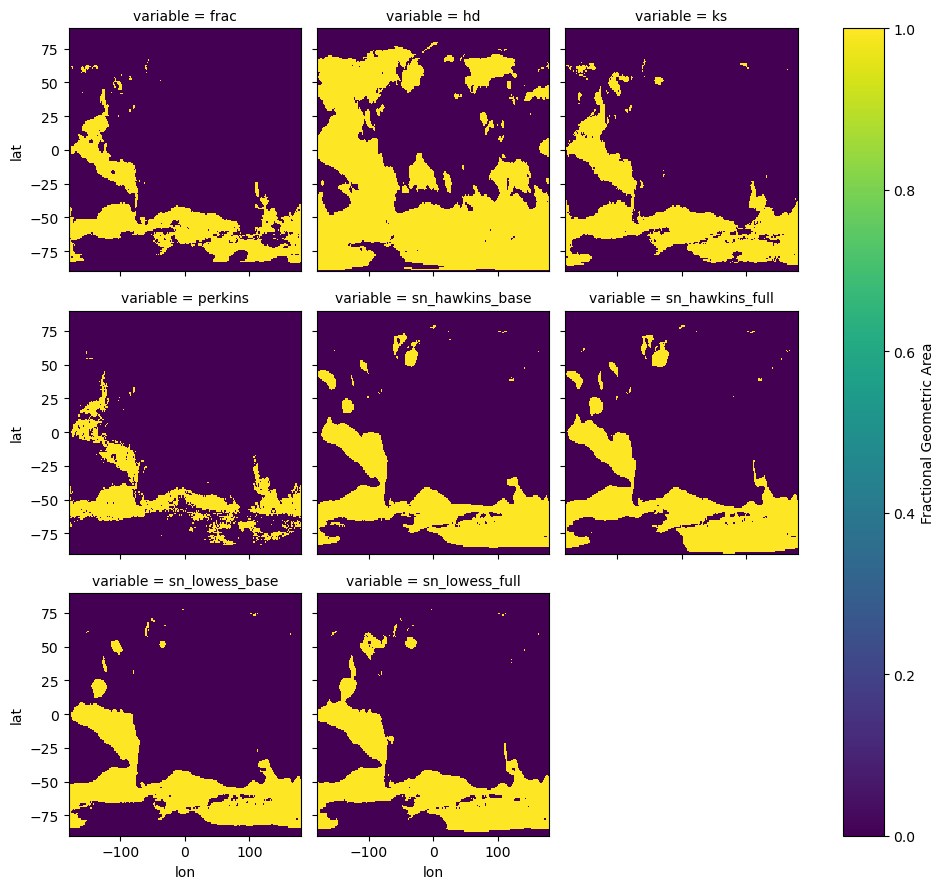

In [31]:
does_not_emerge_tree.best_temperature.to_dataset().to_array().plot(col='variable', col_wrap=3)

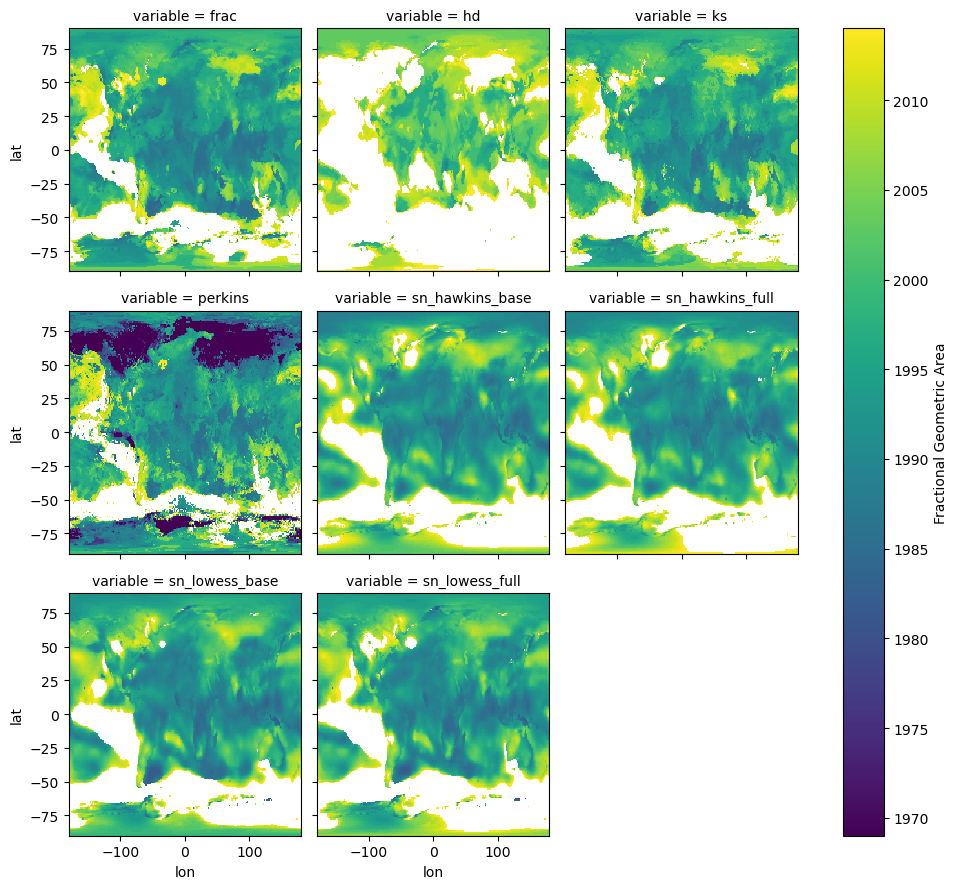

In [54]:
toe_tree.best_temperature.to_dataset().to_array().plot(col='variable', col_wrap=3)

In [219]:
import time_of_emergence_data_analysis as toe_da

In [221]:
binary_emergence_ds = xr.apply_ufunc(
    toe_da.calculate_returned_binary_ds,
    toe_metric_tree.best_temperature.to_dataset(),
    toe_tree.best_temperature.to_dataset(),
    toe_metric_tree.best_temperature.time.dt.year.values,
    input_core_dims = [['time'], [], ['time']],
    output_core_dims=[['time']],
    vectorize=True,
    dask='parallelized'
)

In [224]:
weights = toe_da.compute_weights(binary_emergence_ds)
weights

<xarray.DataArray 'weights' (lat: 180)> Size: 720B
array([0.00872656, 0.02617699, 0.04361945, 0.06104851, 0.07845908,
       0.09584576, 0.11320324, 0.13052624, 0.14780948, 0.16504757,
       0.18223551, 0.19936794, 0.21643965, 0.23344542, 0.25037998,
       0.26723838, 0.28401536, 0.30070582, 0.3173047 , 0.33380693,
       0.35020736, 0.3665012 , 0.38268346, 0.3987491 , 0.4146933 ,
       0.43051115, 0.44619778, 0.4617486 , 0.47715878, 0.49242356,
       0.5075384 , 0.5224986 , 0.5372996 , 0.551937  , 0.56640625,
       0.58070296, 0.59482276, 0.6087614 , 0.62251467, 0.6360782 ,
       0.64944804, 0.66262007, 0.67559016, 0.68835455, 0.70090926,
       0.71325046, 0.72537434, 0.7372773 , 0.7489557 , 0.76040596,
       0.77162457, 0.78260815, 0.7933533 , 0.8038569 , 0.8141155 ,
       0.8241262 , 0.83388585, 0.8433914 , 0.85264015, 0.8616291 ,
       0.87035567, 0.87881714, 0.8870108 , 0.89493436, 0.90258527,
       0.9099613 , 0.9170601 , 0.9238795 , 0.9304176 , 0.9366722 ,
       0.9426415 , 0.94832367, 0.95371693, 0.95881975, 0.96363044,
       0.96814764, 0.9723699 , 0.976296  , 0.9799247 , 0.9832549 ,
       0.9862856 , 0.9890159 , 0.9914449 , 0.9935719 , 0.9953962 ,
       0.9969173 , 0.9981348 , 0.99904823, 0.99965733, 0.9999619 ,
       0.9999619 , 0.99965733, 0.99904823, 0.9981348 , 0.9969173 ,
       0.9953962 , 0.9935719 , 0.9914449 , 0.9890159 , 0.9862856 ,
       0.9832549 , 0.9799247 , 0.976296  , 0.9723699 , 0.96814764,
       0.96363044, 0.95881975, 0.95371693, 0.94832367, 0.9426415 ,
       0.9366722 , 0.9304176 , 0.9238795 , 0.9170601 , 0.9099613 ,
       0.90258527, 0.89493436, 0.8870108 , 0.87881714, 0.87035567,
       0.8616291 , 0.85264015, 0.8433914 , 0.83388585, 0.8241262 ,
       0.8141155 , 0.8038569 , 0.7933533 , 0.78260815, 0.77162457,
       0.76040596, 0.7489557 , 0.7372773 , 0.72537434, 0.71325046,
       0.70090926, 0.68835455, 0.67559016, 0.66262007, 0.64944804,
       0.6360782 , 0.62251467, 0.6087614 , 0.59482276, 0.58070296,
       0.56640625, 0.551937  , 0.5372996 , 0.5224986 , 0.5075384 ,
       0.49242356, 0.47715878, 0.4617486 , 0.44619778, 0.43051115,
       0.4146933 , 0.3987491 , 0.38268346, 0.3665012 , 0.35020736,
       0.33380693, 0.3173047 , 0.30070582, 0.28401536, 0.26723838,
       0.25037998, 0.23344542, 0.21643965, 0.19936794, 0.18223551,
       0.16504757, 0.14780948, 0.13052624, 0.11320324, 0.09584576,
       0.07845908, 0.06104851, 0.04361945, 0.02617699, 0.00872656],
      dtype=float32)
Coordinates:
  * lat      (lat) float32 720B -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5

In [ ]:
toe_da.percentage_lat_lons(ds_region, only_1s_ds_region, weights)

In [ ]:
emergence_time_series_ds = 

In [ ]:
# Calculate the percent of points stable for different reiogns
emergence_time_series_ds = toe.calculate_percent_stable_for_regions(binary_emergence_ds, land_mask_ds,
                                                                   only_1s_ds = data_availability_mask, 
                                                                    logginglevel='ERROR')

emergence_time_series_ds

In [217]:
# def anom_at_emergence(temp_anoms, year_int):
#     if np.isnan(year_int): return np.nan
#     return temp_anoms[int(year_int)]

In [191]:
# anom_at_emergence_da = xr.apply_ufunc(
#     anom_at_emergence, 
#     signal_tree['era5_t2m'].signal_lowess.sortby('lat'), 
#     toe_tree['era5_t2m'].sn_lowess_full.sortby('lat')- data_tree['era5_t2m'].time.dt.year.values[0],
#     input_core_dims=[['time'], []],
#     output_core_dims=[[]],
#     vectorize=True,
#     dask='parallelized',  # Add for Dask compatibility if using chunked data
#     output_dtypes=[float]  # Specify dtype of the output
# )

In [216]:
# metrics = list(toe_tree[list(toe_tree)[0]])
# metrics

In [200]:
# for variable in list(toe_tree):
#     for metric in metrics:

#         anom_at_emergence_da = xr.apply_ufunc(
#             anom_at_emergence, 
#             signal_tree[variable].signal_lowess, 
#             toe_tree[variable][mertric] - data_tree[variable].time.dt.year.values[0],
#             input_core_dims=[['time'], []],
#             output_core_dims=[[]],
#             vectorize=True,
#             dask='parallelized',
#             output_dtypes=[float] 
#         )

#     anom_at_emergence_da_tree = xr.DataTree()

<h1 style='color:cyan'> Plots</h1>

In [55]:
import matplotlib.gridspec as gridspec
import matplotlib.colors as mcolors

In [56]:
# Create a custom colormap with two colors: gray and transparent
colors = [(0, 0, 0, 0), (0.5, 0.5, 0.5, 1)]  # (R, G, B, Alpha)
cmap_binary = mcolors.LinearSegmentedColormap.from_list("binary_no_color", colors)

In [57]:
list(does_not_emerge_tree)

['best_temperature', 'era5_t2m', 'gpcc_precip', 'access_pr', 'era5_tcw']

In [58]:
# toe_emergence_levels = np.arange(toe_metric_tree[list(toe_metric_tree)[0]].to_dataset().time.dt.year.values[0],
#                                  toe_metric_tree[list(toe_metric_tree)[0]].to_dataset().time.dt.year.values[-1], 5)

# toe_emergence_levels

array([1969, 1974, 1979, 1984, 1989, 1994, 1999, 2004, 2009])

In [73]:
from dataclasses import dataclass

@dataclass
class PlotLevels:
    start: int
    stop: int
    step: int

    def generate_range(self):
        """Generate a numpy array based on the start, stop, and step."""
        return np.arange(self.start, self.stop, self.step)

In [74]:
PLOT_LEVELS = {
    'best_temperature': PlotLevels(start=1970, stop=2015, step=5),
    'era5_t2m': PlotLevels(start=1970, stop=2015, step=5),
    'access_pr': PlotLevels(start=1970, stop=2300, step=20)
}

In [76]:
PLOT_LEVELS['best_temperature'].generate_range()

array([1970, 1975, 1980, 1985, 1990, 1995, 2000, 2005, 2010])

In [84]:
def plot_toe_maps(toe_ds, does_not_emerge_ds, name, tests_subset_used=None, axes=None, gs=None):
    toe_emergence_levels = PLOT_LEVELS[name].generate_range()
    # np.arange(toe_metrics_ds.time.dt.year.values[0],
    #                              toe_metrics_ds.time.dt.year.values[-1], 5)

    if tests_subset_used == None: tests_subset_used = list(toe_ds)
    
    if axes is None:
        fig = plt.figure(figsize=(8, 4*len(tests_subset_used)))
        projection=ccrs.PlateCarree()
    
        gs = gridspec.GridSpec(2, len(tests_subset_used), 2, width_ratios=[0.1, 1],
                               hspace=0.2, wspace=0.2)
        axes = [
            fig.add_subplot(gs[i, 1], projection=projection) for i in range(len(tests_subset_used))]
    
    not_stable_kwargs2 = dict(cmap=cmap_binary, add_colorbar=False)
    toe_plot_kwargs = dict(cmap='RdYlBu',add_colorbar=False, levels=toe_emergence_levels)

    
    for ax, test in zip(axes, tests_subset_used):
    
        does_not_emerge_ds[test].plot(ax=ax, **not_stable_kwargs2)
        toe_plot = toe_ds[test].plot(ax=ax, **toe_plot_kwargs)
        title =  toe_const.NAME_CONVERSION_DICT.get(test, test)
        ax.set_title(title, fontsize=15)
        ax.coastlines()
    
    cbar_axes1 = plt.subplot(gs[:, 0])
    cbar1 = plt.colorbar(toe_plot, cax=cbar_axes1, orientation='vertical')
    # cbar1.ax.set_title('Year of Emergence', fontsize=16)
    cbar1.ax.set_ylabel('Year of Emergence', fontsize=16)

    axes[0].set_title(name, fontsize=22)
    
    # Add a legend for both the hatching and "Does Not Emerge"
    legend_elements = [
        plt.Rectangle([0, 0], 1, 1, fc='grey', alpha=0.5)  # Gray for "Does Not Emerge"
        # plt.Rectangle([0, 0], 1, 1, fc='white', hatch='//', edgecolor='black', lw=0.5),

    ]
    legend_labels = [ 'Does Not Emerge']#'Not Enough Data',]
    # legend_elements = legend_elements[-1]
    legend = cbar_axes1.legend(legend_elements, legend_labels, loc='upper center',
                               bbox_to_anchor=(6, 1.09), fontsize=10, ncol=2)

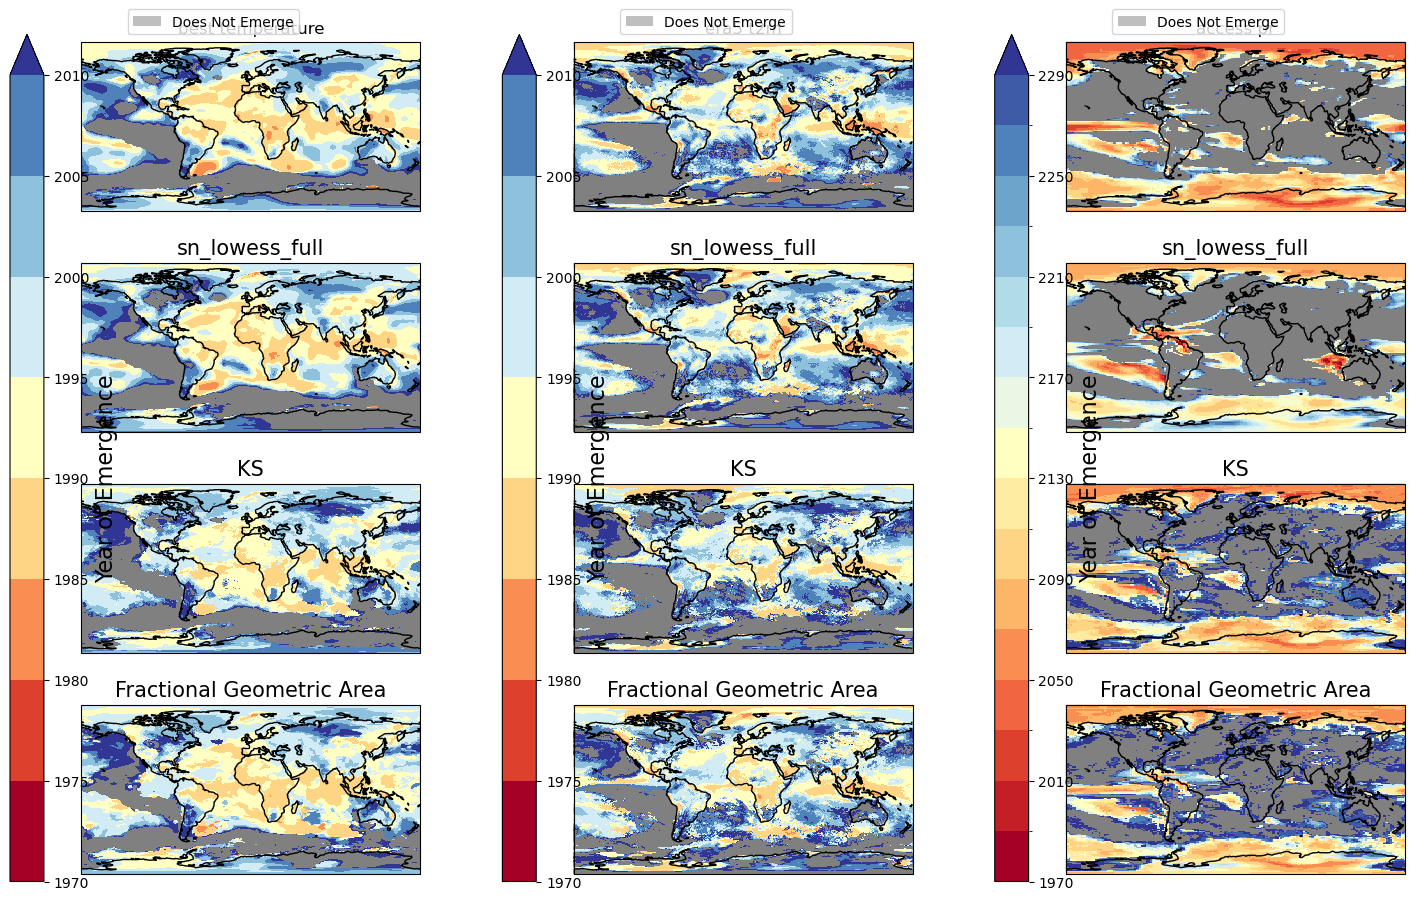

In [85]:
tests_subset_used = ['sn_lowess_base', 'sn_lowess_full', 'ks', 'frac']#, 'perkins', 'hd']
tests_var_used = ['best_temperature', 'era5_t2m', 'access_pr']


fig = plt.figure(figsize=(6*len(list(tests_var_used)), 11))
outer_gs = gridspec.GridSpec(1, len(list(tests_var_used)))


for num,variable in enumerate(list(tests_var_used)):
    inner_gs = gridspec.GridSpecFromSubplotSpec(
        len(tests_subset_used), 2, subplot_spec=outer_gs[num],
        width_ratios=[0.1, 1], hspace=0.2, wspace=0.2)


    axes = [fig.add_subplot(inner_gs[i, 1], projection=ccrs.PlateCarree()) for i in range(len(tests_subset_used))]

    plot_toe_maps(toe_tree[variable].to_dataset(),
                  does_not_emerge_tree[variable].to_dataset(),
                  variable,
                  tests_subset_used, axes, inner_gs)

    axes[0].set_title(variable.replace('_', ' '))


In [209]:
def create_discrete_colorbar(cmap, levels, cax, label):
    """
    Create a discrete colorbar with the given colormap and levels.
    
    Args:
        cmap: Colormap to use.
        levels: Discrete levels (boundaries).
        cax: Colorbar axis.
        label: Label for the colorbar.
    """
    norm = mpl.colors.BoundaryNorm(boundaries=levels, ncolors=cmap.N)
    sm = mpl.cm.ScalarMappable(cmap=cmap, norm=norm)
    cbar = fig.colorbar(sm, cax=cax, orientation='vertical')
    # cbar.set_label(label, fontsize=16)
    cbar.ax.set_title(label, fontsize=12)
    return cbar

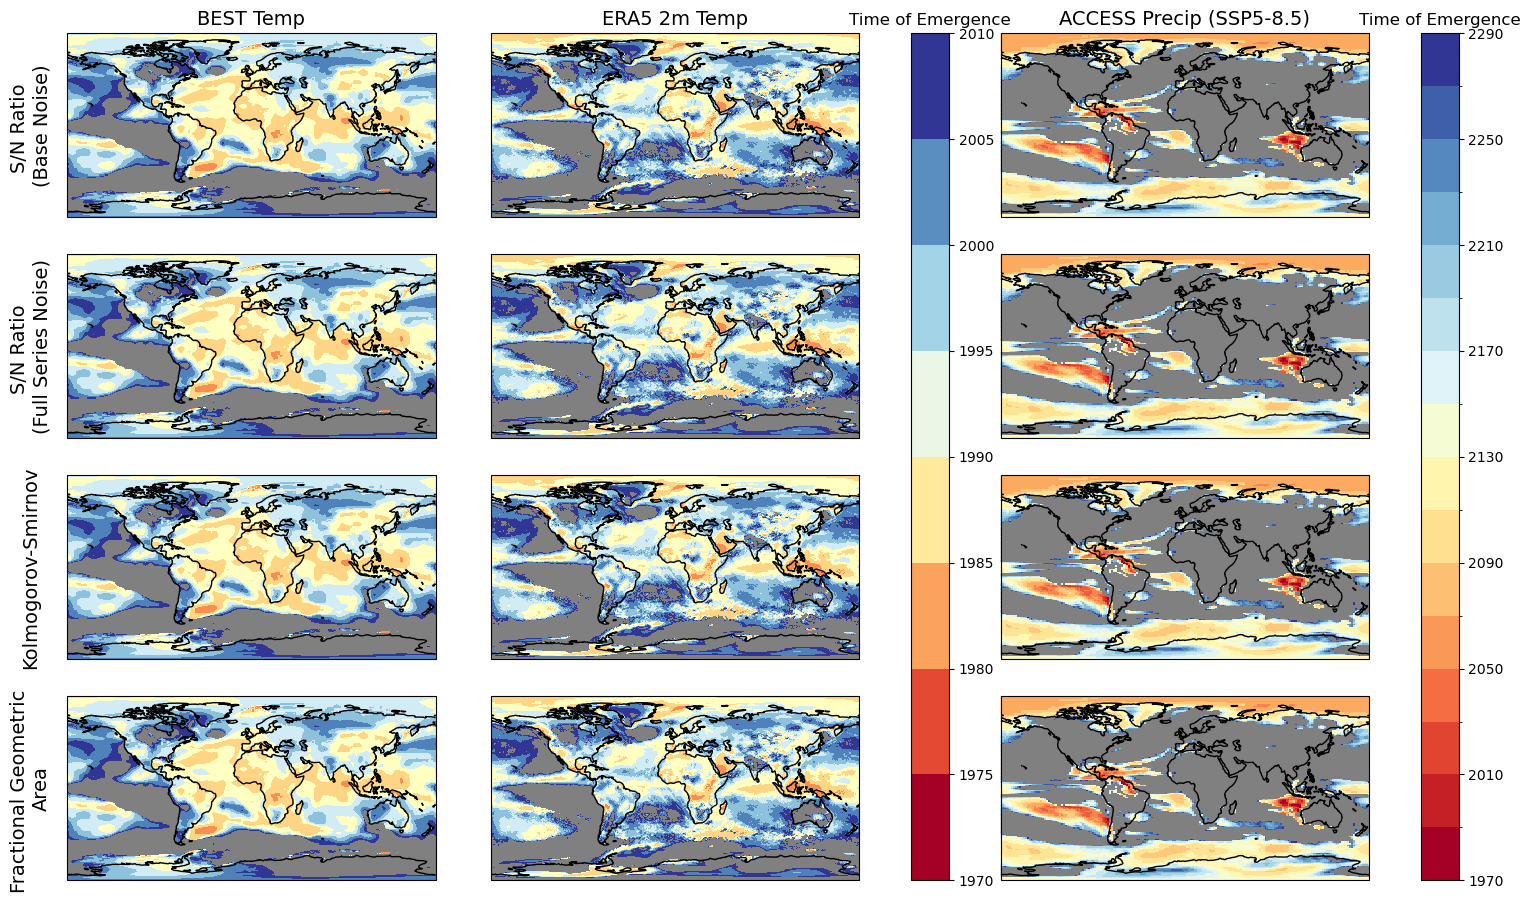

In [215]:
tests_subset_used = ['sn_lowess_base', 'sn_lowess_full', 'ks', 'frac']#, 'perkins', 'hd']
tests_var_used = ['best_temperature', 'era5_t2m', 'access_pr']


fig = plt.figure(figsize=(6*len(list(tests_var_used)), 11))
gs  = gridspec.GridSpec(len(tests_subset_used), len(tests_var_used) +2, 
                       width_ratios = [1, 1, 0.1, 1, 0.1])


axes = np.array([
    [fig.add_subplot(gs[row, col], projection=ccrs.PlateCarree()) for col in [0, 1, 3]]
    for row in range(len(tests_subset_used))
])

caxes = [plt.subplot(gs[:, col]) for col in [2, 4]]

for col,variable in enumerate(list(tests_var_used)):

    toe_emergence_levels = PLOT_LEVELS[variable].generate_range()

    not_stable_kwargs2 = dict(cmap=cmap_binary, add_colorbar=False)
    toe_plot_kwargs = dict(cmap='RdYlBu',add_colorbar=False, levels=toe_emergence_levels)

    for row, metric in enumerate(tests_subset_used):

        ax = axes[row, col]
        does_not_emerge_tree[variable].to_dataset()[test].plot(ax=ax, **not_stable_kwargs2)
        toe_plot = toe_tree[variable].to_dataset()[test].plot(ax=ax, **toe_plot_kwargs)

        ax.coastlines()

        if col == 0:
            row_label = toe_const.NAME_CONVERSION_DICT.get(metric, metric).replace('(', '\n(')
            if 'LOWESS' in row_label: row_label = row_label.replace('LOWESS, ', '')
            if 'Area' in row_label: row_label = row_label.replace('Area', '\nArea')
            ax.annotate(row_label, xy=(-0.1, 0.5), xycoords = 'axes fraction',
                                 rotation=90, ha='center', va='center', fontsize=14)
            
        if row == 0: ax.set_title(toe_const.VARIABLE_CONVERSION_DICT.get(variable, variable), fontsize=14)



# Define the colormap
toe_cmap = plt.cm.RdYlBu

# Create colorbars
cbar1 = create_discrete_colorbar(toe_cmap, PLOT_LEVELS['best_temperature'].generate_range(), caxes[0], 'Time of Emergence')
cbar2 = create_discrete_colorbar(toe_cmap, PLOT_LEVELS['access_pr'].generate_range(), caxes[1], 'Time of Emergence')

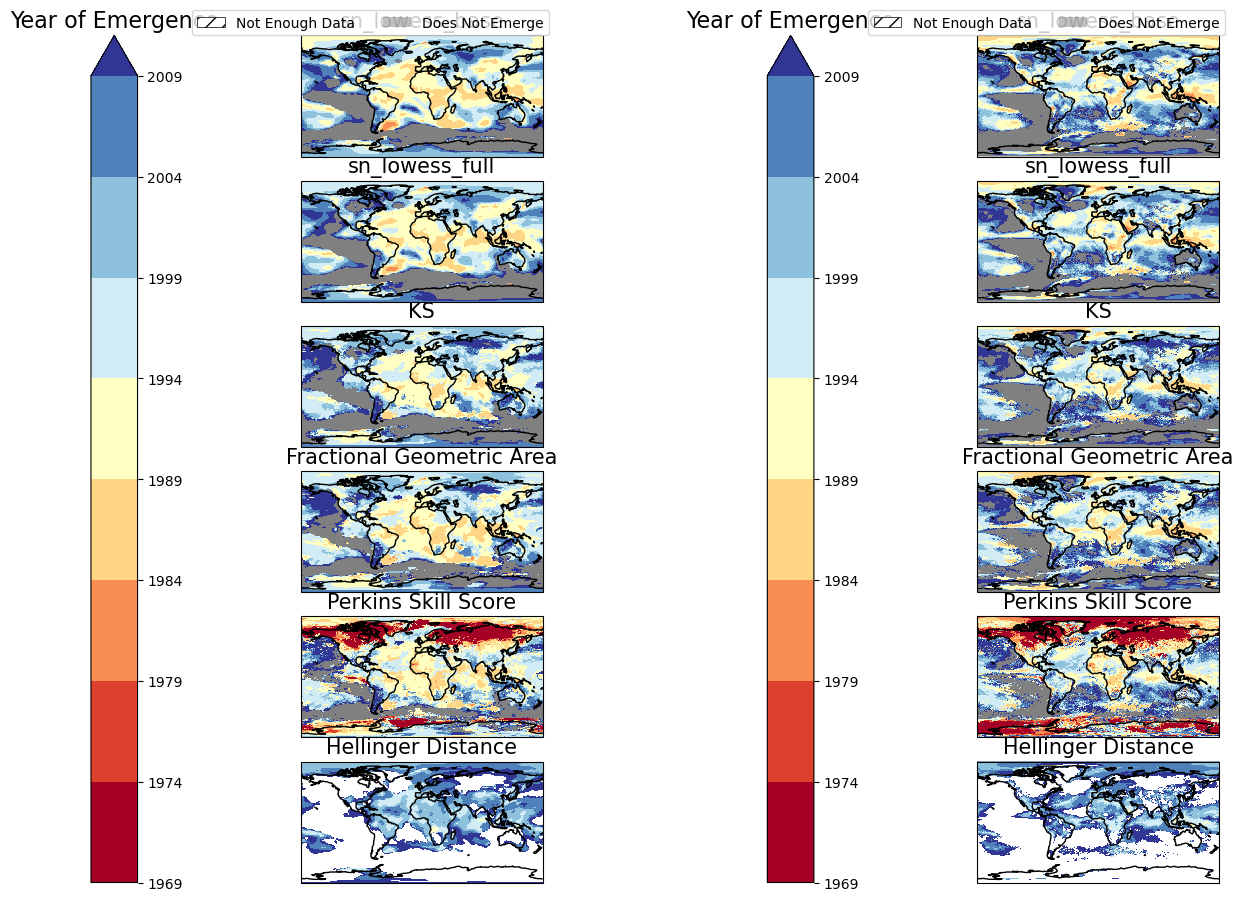

In [107]:
fig = plt.figure(figsize=(16, 11))
outer_gs = gridspec.GridSpec(1, 2)

tests_subset_used = ['sn_lowess_base', 'sn_lowess_full', 'ks', 'frac', 'perkins', 'hd']

inner_gs1 = gridspec.GridSpecFromSubplotSpec(
    len(tests_subset_used), 2, subplot_spec=outer_gs[0],
    width_ratios=[0.1, 1], hspace=0.2, wspace=0.2)

inner_gs2 = gridspec.GridSpecFromSubplotSpec(
    len(tests_subset_used), 2, subplot_spec=outer_gs[1],
    width_ratios=[0.1, 1], hspace=0.2, wspace=0.2)

axes1 = [fig.add_subplot(inner_gs1[i, 1], projection=ccrs.PlateCarree()) for i in range(len(tests_subset_used))]

axes2 = [fig.add_subplot(inner_gs2[i, 1], projection=ccrs.PlateCarree()) for i in range(len(tests_subset_used))]

plot_toe_maps(toe_tree.best_temperature.to_dataset(), does_not_emerge_tree.best_temperature.to_dataset(),
              tests_subset_used, axes1, inner_gs1)
plot_toe_maps(toe_tree.era5_t2m.to_dataset(), does_not_emerge_tree.era5_t2m.to_dataset(), tests_subset_used, axes2, inner_gs2)


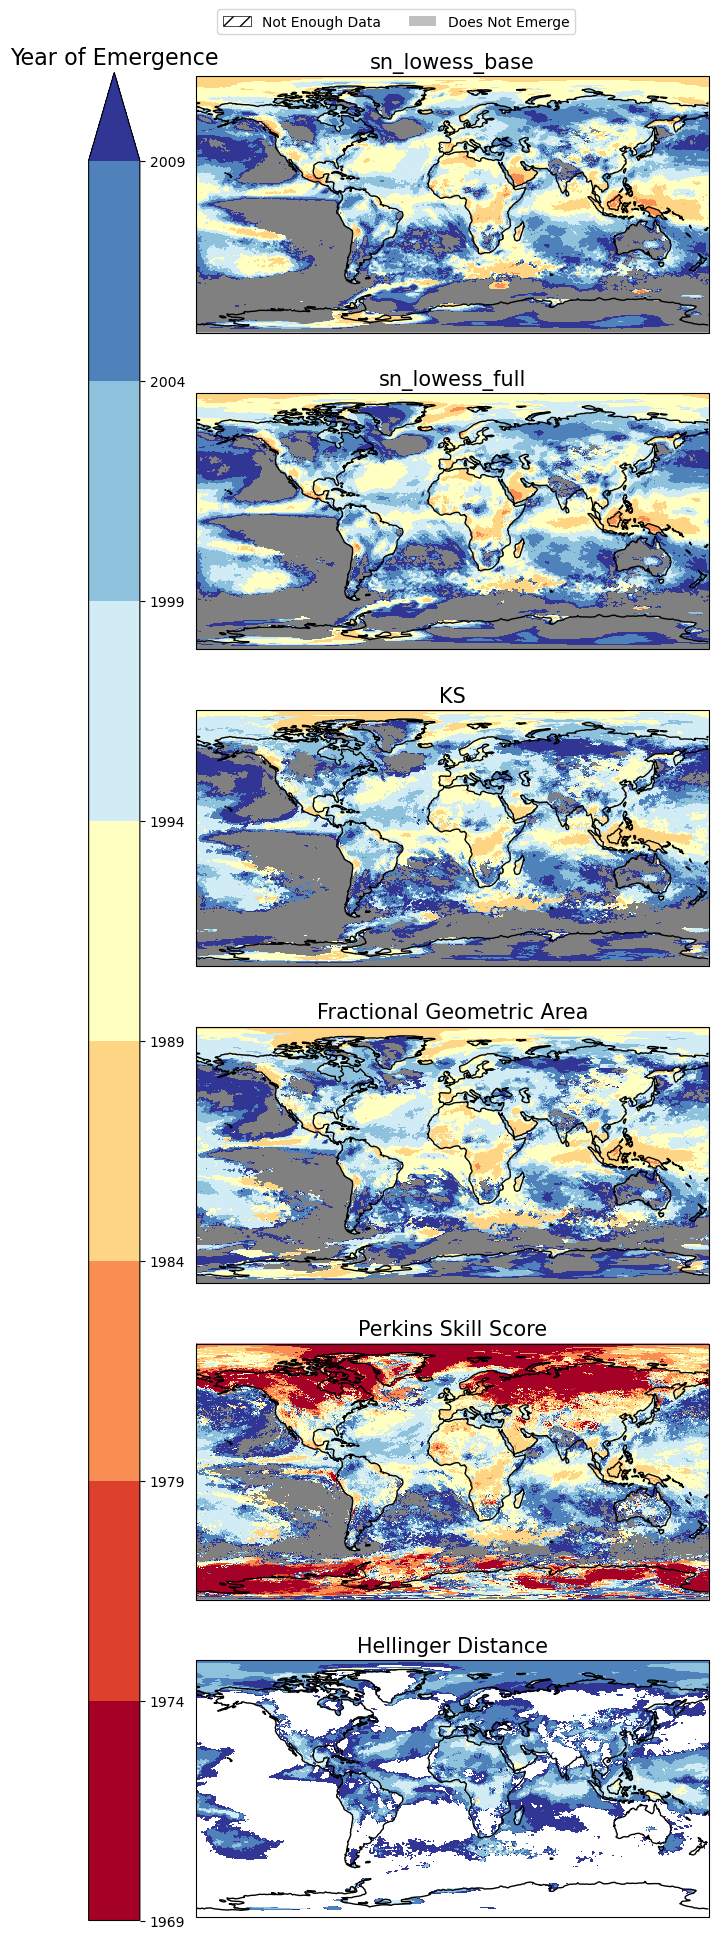

In [147]:
tests_subset_used = ['sn_lowess_base', 'sn_lowess_full', 'ks', 'frac', 'perkins', 'hd']

fig = plt.figure(figsize=(8, 4*len(tests_subset_used)))
projection=ccrs.PlateCarree()

gs = gridspec.GridSpec(len(tests_subset_used), 2, width_ratios=[0.1, 1], hspace=0.2, wspace=0.2)
axes = [fig.add_subplot(gs[i, 1], projection=projection) for i in range(len(tests_subset_used))]

not_stable_kwargs2 = dict(cmap=cmap_binary, add_colorbar=False)
toe_plot_kwargs = dict(cmap='RdYlBu',add_colorbar=False, levels=toe_emergence_levels)


for ax, test in zip(axes, tests_subset_used):

    does_not_emerge_ds2[test].plot(ax=ax, **not_stable_kwargs2)
    toe_plot = toe_ds2[test].plot(ax=ax, **toe_plot_kwargs)
    title =  toe_const.NAME_CONVERSION_DICT.get(test, test)
    ax.set_title(title, fontsize=15)
    ax.coastlines()

cbar_axes1 = plt.subplot(gs[:, 0])
cbar1 = plt.colorbar(toe_plot, cax=cbar_axes1, orientation='vertical')
cbar1.ax.set_title('Year of Emergence', fontsize=16)

# Add a legend for both the hatching and "Does Not Emerge"
legend_elements = [
    plt.Rectangle([0, 0], 1, 1, fc='white', hatch='//', edgecolor='black', lw=0.5),
    plt.Rectangle([0, 0], 1, 1, fc='grey', alpha=0.5)  # Gray for "Does Not Emerge"
]
legend_labels = ['Not Enough Data', 'Does Not Emerge']
legend = cbar_axes1.legend(legend_elements, legend_labels, loc='upper center',
                           bbox_to_anchor=(6, 1.09), fontsize=10, ncol=2)